
# SECOM Semiconductor Yield Prediction — Clean Notebook

**Objective:** Predict pass/fail for semiconductor wafer lots using the UCI SECOM dataset.  
**Scope:** Data audit → preprocessing → baselines → advanced models → interpretability → **cost‑sensitive evaluation** → conclusion.  
**Why it matters:** In fabs, missing a fail (FN) is often costlier than a false alarm (FP). We therefore report classic metrics **and** FN:FP cost analysis with crossover points.


## 1. Setup

In [1]:

# Libraries
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
plt.rcParams['figure.dpi'] = 120
sns.set_context("notebook")

# Reproducibility
RNG = 42
np.random.seed(RNG)

# Paths
DATA_DIR = Path("../data")
RESULTS  = Path("../results"); RESULTS.mkdir(exist_ok=True, parents=True)

print("DATA_DIR:", DATA_DIR.resolve())


DATA_DIR: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOM Semiconductor Yield Prediction/data


## 2. Load & Audit

In [3]:

# Expect files: secom.data, secom_labels.data (UCI SECOM)
X = pd.read_csv(DATA_DIR/"secom.data", sep=r"\s+", header=None)
y = pd.read_csv(DATA_DIR/"secom_labels.data", sep=r"\s+", header=None, names=["label","timestamp"])

print("Shapes:", X.shape, y.shape)
display(X.head(3)); display(y.head(3))

print("\n--- X info ---"); X.info()
print("\nMissing fraction across features:"); display(X.isna().mean().describe())

print("\nLabel distribution (-1=pass, 1=fail):")
vc = y['label'].value_counts(dropna=False); display(vc)
fail_rate = (y['label']==1).mean(); print(f"Fail rate ≈ {fail_rate:.4f}")


Shapes: (1567, 590) (1567, 2)


,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602


,label,timestamp
0,-1,19/07/2008 11:55:00
1,-1,19/07/2008 12:32:00
2,1,19/07/2008 13:17:00



--- X info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 590 entries, 0 to 589
dtypes: float64(590)
memory usage: 7.1 MB

Missing fraction across features:


count    590.000000
mean       0.045375
std        0.154340
min        0.000000
25%        0.001276
50%        0.003829
75%        0.005743
max        0.911934
dtype: float64


Label distribution (-1=pass, 1=fail):


label
-1    1463
 1     104
Name: count, dtype: int64

Fail rate ≈ 0.0664


## 3. Preprocess

In [4]:

# Labels to {0,1}; drop constant features; median-impute; standardize
y_bin = y['label'].map({-1:0, 1:1}).astype('int8')

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

const_cols = X.columns[X.nunique(dropna=True) <= 1]
Xr = X.drop(columns=const_cols) if len(const_cols)>0 else X.copy()

imputer = SimpleImputer(strategy='median').fit(Xr)
X_imp   = imputer.transform(Xr)

scaler  = StandardScaler().fit(X_imp)
X_std   = scaler.transform(X_imp)

print("Dropped constants:", len(const_cols))
print("Final feature count:", X_std.shape[1])


Dropped constants: 116
Final feature count: 474


## 4. Chronological split

In [5]:

# Preserve order as proxy for time: 70% train, 15% val, 15% test
n = len(X_std); i1, i2 = int(0.70*n), int(0.85*n)
Xtr, Xval, Xte = X_std[:i1], X_std[i1:i2], X_std[i2:]
ytr, yval, yte = y_bin.iloc[:i1], y_bin.iloc[i1:i2], y_bin.iloc[i2:]

print(f"Split sizes -> train:{len(ytr)}  val:{len(yval)}  test:{len(yte)}")
print("Fail rates -> train:", ytr.mean().round(4), "| val:", yval.mean().round(4), "| test:", yte.mean().round(4))


Split sizes -> train:1096  val:235  test:236
Fail rates -> train: 0.0712 | val: 0.0723 | test: 0.0381


## 5. Baselines (Logistic, RandomForest, XGBoost)

In [6]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, roc_auc_score, balanced_accuracy_score

def fit_eval_probs(clf, Xtr, ytr, Xte, yte, name):
    clf.fit(Xtr, ytr)
    p = clf.predict_proba(Xte)[:,1]
    return {
        "Model": name,
        "PR-AUC": average_precision_score(yte, p),
        "ROC-AUC": roc_auc_score(yte, p),
        "BalancedAcc@0.5": balanced_accuracy_score(yte, (p>=0.5).astype(int))
    }, p

res = []
res_lr, p_lr = fit_eval_probs(LogisticRegression(max_iter=5000, class_weight='balanced'), Xtr, ytr, Xte, yte, "Logistic")
res.append(res_lr)

rf = RandomForestClassifier(n_estimators=400, class_weight='balanced', random_state=RNG, n_jobs=-1)
res_rf, p_rf = fit_eval_probs(rf, Xtr, ytr, Xte, yte, "RandomForest")
res.append(res_rf)

# XGBoost (if available)
try:
    from xgboost import XGBClassifier
    scale_pos_weight = (1 - ytr.mean()) / (ytr.mean() + 1e-12)
    xgb = XGBClassifier(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=RNG,
        scale_pos_weight=scale_pos_weight, n_jobs=-1
    )
    res_xgb, p_xgb = fit_eval_probs(xgb, Xtr, ytr, Xte, yte, "XGBoost")
    res.append(res_xgb)
except Exception as e:
    p_xgb = np.zeros_like(yte, dtype=float)
    res.append({"Model":"XGBoost","PR-AUC":np.nan,"ROC-AUC":np.nan,"BalancedAcc@0.5":np.nan})
    print("XGBoost unavailable:", e)

baseline_df = pd.DataFrame(res).round(4); display(baseline_df)


,Model,PR-AUC,ROC-AUC,BalancedAcc@0.5
0,Logistic,0.0562,0.6006,0.4846
1,RandomForest,0.0993,0.5191,0.5000
2,XGBoost,0.0678,0.6437,0.5000


## 6. Advanced: MLP (Weighted BCE and Focal-like)

In [9]:
# PyTorch MLP baselines; uses CPU or Apple MPS if available.
import warnings
warnings.filterwarnings("ignore")

try:
    import torch, torch.nn as nn
    # Force float32 globally (important for MPS)
    torch.set_default_dtype(torch.float32)

    device = torch.device(
        "mps" if torch.backends.mps.is_available()
        else ("cuda" if torch.cuda.is_available() else "cpu")
    )
    print("Torch device:", device)

    class MLP(nn.Module):
        def __init__(self, d_in):
            super().__init__()
            self.f = nn.Sequential(
                nn.Linear(d_in, 256), nn.ReLU(), nn.Dropout(0.2),
                nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.2),
                nn.Linear(128, 1)   # logits
            )
        def forward(self, x):
            return self.f(x)

    def to_float32(x):
        # ensure numpy float32 before tensorization
        return x.astype("float32", copy=False)

    def train_mlp(Xtrain, ytrain, Xval, yval, Xtest, loss="weighted_bce", epochs=40, lr=1e-3):
        # Cast inputs to float32 early
        Xtrain = to_float32(Xtrain); Xval = to_float32(Xval); Xtest = to_float32(Xtest)

        Xt  = torch.tensor(Xtrain, dtype=torch.float32, device=device)
        yt  = torch.tensor(ytrain.values, dtype=torch.float32, device=device).unsqueeze(1)
        Xv  = torch.tensor(Xval,   dtype=torch.float32, device=device)
        Xts = torch.tensor(Xtest,  dtype=torch.float32, device=device)

        m = MLP(Xtrain.shape[1]).to(device)

        if loss == "weighted_bce":
            pos_w = float((1 - ytrain.mean()) / (ytrain.mean() + 1e-12))
            crit = nn.BCEWithLogitsLoss(
                pos_weight=torch.tensor([pos_w], dtype=torch.float32, device=device)
            )
        else:
            # Focal-like: alpha=0.75, gamma=2
            alpha, gamma = 0.75, 2.0
            bce = nn.BCEWithLogitsLoss(reduction="none")
            def focal_loss(logits, targets):
                # logits, targets both float32 on device
                b  = bce(logits, targets)
                p  = torch.sigmoid(logits)
                pt = targets * p + (1 - targets) * (1 - p)
                return (alpha * (1.0 - pt)**gamma * b).mean()
            crit = focal_loss

        opt = torch.optim.Adam(m.parameters(), lr=lr)

        best_ap = -1.0
        best_state = None
        from sklearn.metrics import average_precision_score

        for ep in range(epochs):
            m.train()
            opt.zero_grad()
            logits = m(Xt)
            loss_v = crit(logits, yt)
            loss_v.backward()
            opt.step()

            # validation AP
            m.eval()
            with torch.no_grad():
                pv = torch.sigmoid(m(Xv)).detach().cpu().numpy().ravel().astype("float32")
            ap = average_precision_score(yval, pv)
            if ap > best_ap:
                best_ap = ap
                best_state = {k: v.detach().cpu().clone() for k, v in m.state_dict().items()}

        if best_state is not None:
            m.load_state_dict({k: v.to(device) for k, v in best_state.items()})

        m.eval()
        with torch.no_grad():
            p_test = torch.sigmoid(m(Xts)).detach().cpu().numpy().ravel().astype("float32")
        return p_test, best_ap

    # Train both heads
    p_mlp_w, ap_w = train_mlp(Xtr, ytr, Xval, yval, Xte, loss="weighted_bce", epochs=60)
    p_mlp_f, ap_f = train_mlp(Xtr, ytr, Xval, yval, Xte, loss="focal",        epochs=60)

    from sklearn.metrics import average_precision_score, roc_auc_score, balanced_accuracy_score
    rows = []
    for name, p in [("MLP (weighted BCE)", p_mlp_w), ("MLP (Focal)", p_mlp_f)]:
        rows.append({
            "Model": name,
            "PR-AUC": average_precision_score(yte, p),
            "ROC-AUC": roc_auc_score(yte, p),
            "BalancedAcc@0.5": balanced_accuracy_score(yte, (p>=0.5).astype(int))
        })
    display(pd.DataFrame(rows).round(4))

except Exception as e:
    print("Torch not available or error:", e)
    p_mlp_w = np.zeros_like(yte, dtype=float)
    p_mlp_f = np.zeros_like(yte, dtype=float)

Torch device: mps


,Model,PR-AUC,ROC-AUC,BalancedAcc@0.5
0,MLP (weighted BCE),0.0793,0.6725,0.6632
1,MLP (Focal),0.0470,0.4944,0.4652


## 7. Interpretability — SHAP on XGBoost (if available)

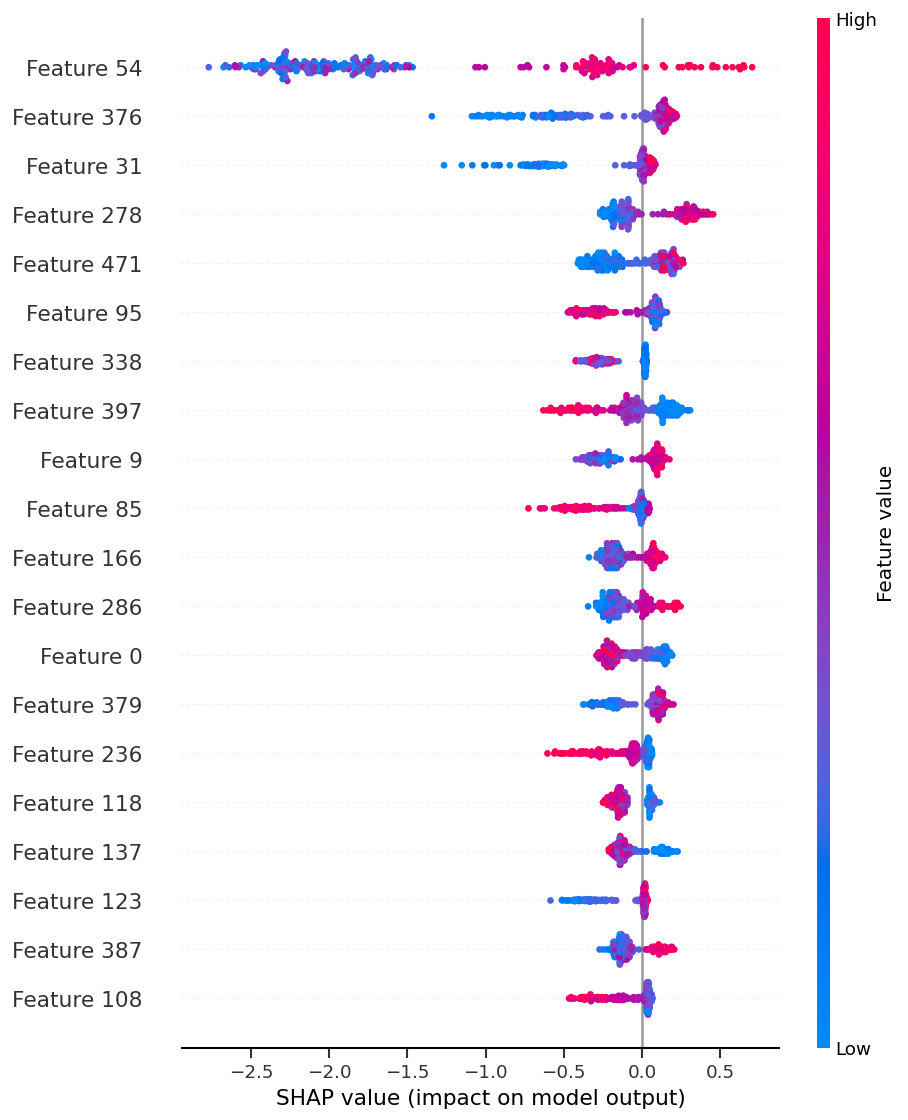

In [10]:

try:
    import shap
    expl = shap.TreeExplainer(xgb)
    shap_vals = expl.shap_values(Xte)
    shap.summary_plot(shap_vals, Xte, show=True)
except Exception as e:
    print("SHAP skipped:", e)


## 8. Cost-sensitive evaluation — FN:FP sweep with **cost‑optimal thresholds**

In [18]:

from sklearn.metrics import precision_recall_curve, confusion_matrix, auc, roc_auc_score, average_precision_score

def best_cost_for_ratio(y_true, p, ratio, thr_grid=None):
    if thr_grid is None:
        P,R,T = precision_recall_curve(y_true, p)
        thr_grid = np.unique(np.r_[T, 0.0, 1.0])
    best = (1e18, None, None)
    for thr in thr_grid:
        pred = (p>=thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
        cost = fp*1 + fn*ratio
        if cost < best[0]:
            best = (cost, thr, (tp, fp, tn, fn))
    return best  # cost, thr, (tp,fp,tn,fn)

# Collect probabilities from fitted models
probs = {"Logistic": p_lr, "RandomForest": p_rf}
if not np.allclose(p_xgb, 0): probs["XGBoost"] = p_xgb
if not np.allclose(p_mlp_w, 0): probs["MLP (weighted BCE)"] = p_mlp_w
if not np.allclose(p_mlp_f, 0): probs["MLP (Focal)"] = p_mlp_f

ratios = list(range(1,101))
rows = []
for name, p in probs.items():
    P,R,T = precision_recall_curve(yte, p)
    thr_grid = np.unique(np.r_[T, 0.0, 1.0])
    for r in ratios:
        cost, thr, (tp,fp,tn,fn) = best_cost_for_ratio(yte, p, r, thr_grid)
        rows.append({"Model":name, "Ratio":r, "Cost":int(cost), "thr":float(thr),
                     "TP":int(tp), "FP":int(fp), "TN":int(tn), "FN":int(fn)})
df_cost = pd.DataFrame(rows)
display(df_cost.head())


,Model,Ratio,Cost,thr,TP,FP,TN,FN
0,Logistic,1,9,1.0,0,0,227,9
1,Logistic,2,18,1.0,0,0,227,9
2,Logistic,3,27,1.0,0,0,227,9
3,Logistic,4,36,1.0,0,0,227,9
4,Logistic,5,45,1.0,0,0,227,9


In [19]:
len(df_cost)

500

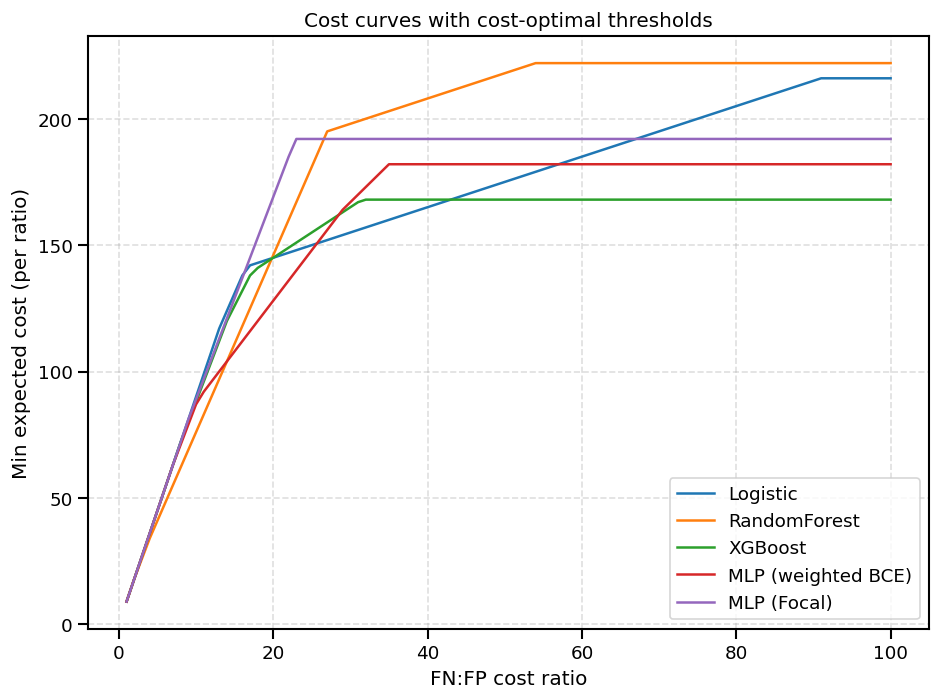

In [20]:

# Plot cost vs ratio curves (key figure)
plt.figure(figsize=(8,6))
for name in probs:
    sub = df_cost[df_cost.Model==name]
    plt.plot(sub["Ratio"], sub["Cost"], label=name)
plt.xlabel("FN:FP cost ratio")
plt.ylabel("Min expected cost (per ratio)")
plt.title("Cost curves with cost‑optimal thresholds")
plt.legend(); plt.grid(True, ls="--", alpha=0.4); plt.tight_layout()
plt.show()


In [21]:

# Crossover vs Logistic
base = df_cost[df_cost.Model=="Logistic"].set_index("Ratio")["Cost"]
for name in probs:
    if name=="Logistic": continue
    other = df_cost[df_cost.Model==name].set_index("Ratio")["Cost"]
    diff = (other - base).reindex(base.index).to_numpy()
    sign = np.sign(diff); change = np.where(sign[:-1]*sign[1:] < 0)[0]
    if change.size:
        print(f"Crossover {name}: FN:FP ≈ {base.index[change[0]+1]}:1")
    else:
        if np.all(diff < 0): print(f"Crossover {name}: always cheaper than Logistic in 1–30")
        elif np.all(diff > 0): print(f"Crossover {name}: always costlier than Logistic in 1–30")
        else: print(f"Crossover {name}: no sign change in 1–30")


Crossover RandomForest: FN:FP ≈ 20:1
Crossover XGBoost: no sign change in 1–30
Crossover MLP (weighted BCE): FN:FP ≈ 26:1
Crossover MLP (Focal): FN:FP ≈ 17:1


## 9. Feature selection — ANOVA‑k40 + Logistic (winner summary)

In [22]:

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(SelectKBest(score_func=f_classif, k=min(40, Xtr.shape[1])),
                     LogisticRegression(max_iter=5000, class_weight='balanced'))
pipe.fit(Xtr, ytr)
p_sel = pipe.predict_proba(Xte)[:,1]
print("ANOVA‑k40 + LR — PR-AUC:", average_precision_score(yte, p_sel).round(4),
      "| ROC-AUC:", roc_auc_score(yte, p_sel).round(4))


ANOVA‑k40 + LR — PR-AUC: 0.0462 | ROC-AUC: 0.5306



## 10. Conclusion

- SECOM is small, imbalanced, and noisy; classical metrics favor Logistic Regression.
- **Cost-sensitive analysis** shows model choice depends on FN:FP economics; several models beat Logistic when FN costs ≥ 4–6× FP.
- For deployment, set thresholds by **expected-cost minimization** under an agreed FN:FP ratio.
- SHAP on tree models highlights top sensors; use these to guide process checks.

**Artifacts saved:** figures in `results/` if you save them explicitly; this notebook is the polished narrative to accompany the exploratory work.



## Appendix (pointer)
PCA, anomaly detection (IF/LOF/AE), calibration, bootstraps, and streaming variants are in the exploratory notebook.
